# Saturating the Cosmological Field Information

by Lucas Makinen [<img src="https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/Orcid-ID.png" alt="drawing" width="20"/>](https://orcid.org/0000-0002-3795-6933 "") [<img src="https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/twitter-graphic.png" alt="drawing" width="20" style="background-color: transparent"/>](https://twitter.com/lucasmakinen?lang=en ""), Tom Charnock [<img src="https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/Orcid-ID.png" alt="drawing" width="20"/>](https://orcid.org/0000-0002-7416-3107 "Redirect to orcid") [<img src="https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/twitter-graphic.png" alt="drawing" width="20" style="background-color: transparent"/>](https://twitter.com/t_charnock?lang=en "")), Justin Alsing [<img src="https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/Orcid-ID.png" alt="drawing" width="20"/>](https://scholar.google.com/citations?user=ICPFL8AAAAAJ&hl=en "Redirect to orcid"), and Ben Wandelt [<img src="https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/twitter-graphic.png" alt="drawing" width="20" style="background-color: transparent"/>](https://twitter.com/bwandelt?lang=en "")

>read the paper: [accompanying arXiv paper](arxiv link)

>get the code:  [https://github.com/tlmakinen/FieldIMNNs](https://github.com/tlmakinen/FieldIMNNs)



In this short walkthrough we will train an optimal neural compression on cosmological fields generated from a fiducial model and demonstrate theoretical information saturation. This code can be run so long as the user has a Google Colab Pro account with increased computational resources. 

First we'll install the relevant libraries and walk through the simulation implementation. Then we'll build a neural IMNN compressor to generate two optimal summaries for our simulations. 

### Q: Wait a second -- how do we know this works ?
If you're not convinced by our method by the end of this tutorial, we invite you to take a look at our [benchmarking tutorial with Gaussian fields from power spectra](https://www.aquila-consortium.org/doc/imnn/pages/examples/2d_field_inference/2d_field_inference.html), which is also runnable in-browser on [this Colab notebook](https://colab.research.google.com/drive/1_y_Rgn3vrb2rlk9YUDUtfwDv9hx774ZF#scrollTo=EW4H-R8I0q6n).

# step 1: loading packages and setting up environment

1.  check that Colab is set to run on a GPU ! Go to `Runtime`>`change runtime type` and select `GPU` from the dropdown menu. Next, enable dark mode by going to `settings`>`Theme` and selecting `dark` (protect your eyes !)

2.   install packages. The current code relies on several libraries, namely `jax` and `tensorflow_probability`. However, we require both plain `tensorflow_probability` (`tfp`) and the experimental `tensorflow_probability.substrates.jax` (`tfpj`) packages for different parts of our inference 
3. for some Colab sessions, you may need to run the second cell so that `!pip install jax-cosmo` gets the package imported properly.

In [1]:
#@title set up environment <font color='lightgreen'>[RUN ME FIRST]</font>
%tensorflow_version 2.x
import tensorflow as tf
print('tf version', tf.__version__)

!pip install -q jax==0.2.11

!pip install -q tensorflow-probability

import tensorflow_probability as tfp
print('tfp version:', tfp.__version__)
tfd = tfp.distributions
tfb = tfp.bijectors

!pip install -q imnn 

!python -m pip install -q jax-cosmo

tf version 2.5.0
     |████████████████████████████████| 604kB 8.0MB/s 
tfp version: 0.13.0
     |████████████████████████████████| 133kB 9.1MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 286kB 9.3MB/s 


In [3]:
# now import all the required libraries
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import jax

print('jax version:', jax.__version__)

# for nn model stuff
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax


# tensorflow-prob VANILLA
tfd = tfp.distributions
tfb = tfp.bijectors

# tensorflow-prob-JAX
import tensorflow_probability.substrates.jax as tfpj

tfdj = tfpj.distributions
tfbj = tfpj.bijectors


# for imnn
import imnn
import imnn.lfi

print('IMNN version:', imnn.__version__)

# jax-cosmo module
!python -m pip install -q jax-cosmo
import jax_cosmo as jc
print('jax-cosmo version:', jc.__version__)

# matplotlib stuff
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
import seaborn as sns
sns.set()


rng = random.PRNGKey(2)

jax version: 0.2.11
IMNN version: 0.3.0
jax-cosmo version: 0.1rc7


note: if the above cell fails for installing jax-cosmo, just run it again: Colab will rearrange the headings needed.

In [4]:
from jax.config import config
config.update('jax_enable_x64', True)

make sure we're using 64-bit precision and running on a GPU !

In [5]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


# Cosmological Fields from the Eisenstein-Hu linear matter power spectrum
We're interested in extracting the cosmological parameters $\Omega_c$ and $\sigma_8$ *directly* from cosmological field pixels. To generate our simulations we'll need to install the library `jax-cosmo` to generate our differentiable model power spectra.

## choose fiducial model
To train our neural compression, we need to choose a fiducial model to train the IMNN.


For example lets say that our fiducial cosmology has $\Omega_c=0.60$ and $\sigma_8=0.60$. This is *deliberately* far from, say, Planck parameters -- we want to investigate how our compression behaves if we don't know our universe's true parameters.

In [13]:
cosmo_params = jc.Planck15(Omega_c=0.60, sigma8=0.60)
θ_fid = np.array(
    [cosmo_params.Omega_c, 
     cosmo_params.sigma8], 
    dtype=np.float32)

n_params = θ_fid.shape[0]

Our power spectrum $P_{\rm LN}(k)$ is the linear matter power spectrum defined as

In [14]:
def P(k, A=0.60, B=0.60):
    cosmo_params = jc.Planck15(Omega_c=A, sigma8=B)
    return jc.power.linear_matter_power(cosmo_params, k)

and we can visualize it in $k$-space (small $k$ <=> big $r$, big $k$ <=> small $r$) :

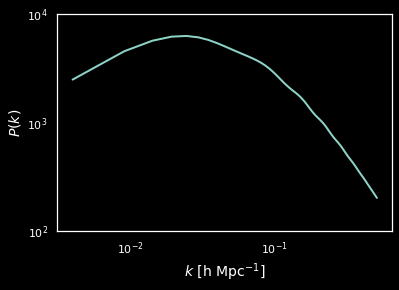

In [10]:
#@title plot the Eisenstein-Hu $P(k)$ <font color='lightgreen'>[run me]</font>

sns.set()
L = 250.
N = 128.
#kmax = 1.0
#kmin = 0.5 / (N)

kmax = N / L
kmin = 1. / L

kbin = np.linspace(kmin, kmax, num=100)

power_spec = P(kbin, A=cosmo_params.Omega_c, B=cosmo_params.sigma8)

plt.style.use('dark_background')
plt.grid(b=None)

plt.plot(kbin, power_spec, linewidth=2)
plt.xlabel(r'$k\ \rm [h\ Mpc^{-1}]$', fontsize=14)
plt.ylabel(r'$P(k)\ \rm$', fontsize=14)
plt.ylim((1e2, 1e4))
plt.xscale('log')
plt.yscale('log')

## Lognormal Fields from Power Spectra: how much information is embedded in the field ?
Cosmologists often use lognormal fields as "the poor man's large scale structure" since they're analytically interrogable and easy to obtain from Gaussian fields. We'll walk through how to obtain the *theoretical* information content of such fields using the Fisher formalism.

The likelihood for an $N_{\rm pix}\times N_{\rm pix}$ Gaussian field, $\boldsymbol{\delta}$, can be explicitly written down for the Fourier transformed data, $\boldsymbol{\Delta}$ as
$$\mathcal{L}(\boldsymbol{\Delta}|\boldsymbol{\theta}) = \frac{1}{(2\pi)^{N_{\rm pix}^2 / 2} |P_{\rm G}({\bf k}, \boldsymbol{\theta})|^{1/2}}\exp{\left(-\frac{1}{2}\boldsymbol{\Delta}\left(P_{\rm G}({\bf k}, \boldsymbol{\theta})\right)^{-1}\boldsymbol{\Delta}\right)}$$
Since the Fisher information can be calculated from the expectation value of the second derivative of the score, i.e. the log likelihood
$${\bf F}_{\alpha\beta} = - \left.\left\langle\frac{\partial^2\ln\mathcal{L}(\Delta|\boldsymbol{\theta})}{\partial\theta_\alpha\partial\theta_\beta}\right\rangle\right|_{\boldsymbol{\theta}=\boldsymbol{\theta}^\textrm{fid}}$$
then we know that analytically the Fisher information must be
$${\bf F}_{\alpha\beta} = \frac{1}{2} {\rm Tr} \left(\frac{\partial P_{\rm G}({\bf k}, \boldsymbol{\theta})}{\partial\theta_\alpha}\left(P_{\rm G}({\bf k}, \boldsymbol{\theta})\right)^{-1}\frac{\partial P_{\rm G}({\bf k}, \boldsymbol{\theta})}{\partial\theta_\beta}\left(P_{\rm G}({\bf k}, \boldsymbol{\theta})\right)^{-1}\right)$$
where $\alpha$ and $\beta$ label the parameters (for instance $ \Omega_c, \sigma_8$) in the power spectrum. As each $k$-mode is uncoupled for this power law form we require the derivatives
$$\begin{align}
\left(\frac{\partial P_{\rm G}({\bf k}, \boldsymbol{\theta})}{\partial \Omega_c},\ 
\frac{\partial P_{\rm G}({\bf k}, \boldsymbol{\theta})}{\partial \sigma_8}\right) \\
\end{align}$$
We can set up these derivative functions *so long as our code for $P(k)$ is differentiable*. 


For *lognormal* fields, this likelihood changes somewhat. Formally, if a random variable $Y$ has a normal distribution, then the exponential function of $Y$, $X = \exp(Y)$, has a log-normal distribution. We will generate our log-normal fields with a power spectrum such that the *lognormal field has the specified $P_{\rm LN}(k)$*. This means that we need to employ the *backwards conversion formula* , presented by [M. Greiner? and T.A. Enßlin](https://arxiv.org/pdf/1312.1354.pdf), to obtain the correct form for $P_{\rm G}(k)$ needed for the above Fisher evaluation:
$$ P_{\rm G} = \int d^u x e^{i \textbf{k} \cdot \textbf{x}} \ln \left( \int \frac{d^u q}{(2\pi)^u} e^{i \textbf{q} \cdot \textbf{x}} P_{\rm LN}(\textbf{q}) \right) $$

which we can do numerically (and differentiably !) in `Jax`:

In [15]:
def ln_fisher(θ, k, N):
    A, B = θ

    def Pgauss(k, A, B):
      return np.real(np.fft.fftn(np.log(np.fft.fftshift(np.fft.ifftn(P(k, A, B))))))


    C_A,C_B = jax.vmap(jax.grad(Pgauss, argnums=(1,2)))(k.flatten(), 
                                        np.repeat(A, len(k.flatten())), 
                                        np.repeat(B, len(k.flatten())))
    
    C_A = C_A.reshape(k.shape)
    C_B = C_B.reshape(k.shape)
    
    pgauss = Pgauss(k, A, B)[1:N // 2, 1:N // 2]
    k = k[1:N // 2, 1:N // 2]

    Cinv = np.diag(1. / pgauss.flatten())

    C_A = np.diag(C_A[1:N // 2, 1:N // 2].flatten())
    C_B = np.diag(C_B[1:N // 2, 1:N // 2].flatten())

    F_AA = 0.5 * np.trace((Cinv @ C_A @ Cinv @ C_A))
    F_AB = 0.5 * np.trace((Cinv @ C_B @ Cinv @ C_A ))
    F_BA = 0.5 * np.trace((Cinv @ C_A @ Cinv @ C_B))
    F_BB = 0.5 * np.trace((Cinv @ C_B @ Cinv @ C_B))

    return np.array([[F_AA, F_AB], [F_BA, F_BB]])

We can now set the simulator arguments, i.e. the $k$-modes to evaluate, the length of the side of a box, the shape of the box and whether to normalise via the volume and squeeze the output dimensions

## choose $k$-modes and define fiducial model
Next, we're going to set our $N$-side to 128 (the size of our data vector), $k$-vector, as well as the $L$-side (the physical dimensions of the universe-in-a-box:

In [16]:
N = 128
shape = (N, N)

k = np.sqrt(
    np.sum(
        np.array(
            np.meshgrid(
                *((np.hstack(
                    (np.arange(0, _shape // 2 + 1),  
                     np.arange(-_shape // 2 + 1, 0)))
                   * 2 * np.pi / _shape)**2.
                  for _shape in shape))), 
        axis=0))

Now that we have the setup, we can compute the theoretical Fisher information for this cosmological power spectrum:

In [17]:
F = ln_fisher(θ_fid, k, int(N))

In [18]:
print('theoretical det F:', np.linalg.det(F))
print('theoretical Shannon information content in nats: ', 0.5*np.log(np.linalg.det(F)))

theoretical det F: 245524.33983948187
theoretical Shannon information content in nats:  6.205575682625643


### Next, we provide you our universe simulator in `jax`. This is how it works:

### 2D random field simulator in jax

To create a 2D lognormal random field we can follow these steps:

1. Generate a $(N_\textrm{pix}\times N_\textrm{pix})$ white noise field $\varphi$ such that $\langle \varphi_k \varphi_{-k} \rangle' = 1$

2. Fourier Transform $\varphi$ to real space: $R_{\rm white}({\bf x}) \rightarrow R_{\rm white}({\bf k})$
   Note that NumPy's DFT Fourier convention is:
   $$\phi_{ab}^{\bf k} = \sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) \phi^{\bf x}_{cd}}$$
   $$\phi_{ab}^{\bf x} = \frac{1}{N^2}\sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) \phi^{\bf k}_{cd}}$$    

3. Evaluate the chosen power spectrum over a field of $k$ values and do the lognormal transformation:
   $$P_{\rm LN}(k) \gets \ln(1 + P(k)) $$
   Here we need to ensure that this array of amplitudes are Hermitian, e.g. $\phi^{* {\bf k}}_{a(N/2 + b)} = \phi^{{\bf k}}_{a(N/2 - b)}$. This is accomplished by choosing indices $k_a = k_b = \frac{2\pi}{N} (0, \dots, N/2, -N/2+1, \dots, -1)$ (as above) and then evaluating the square root of the outer product of the meshgrid between the two: $k = \sqrt{k^2_a + k^2_b}$. We can then evaluate $P_{\rm LN}^{1/2}(k)$.

4. Scale white noise $R_{\rm white}({\bf k})$ by the power spectrum:
   $$R_P({\bf k}) = P_{\rm LN}^{1/2}(k) R_{\rm white}({\bf k}) $$
   
5. Fourier Transform $R_{P}({\bf k})$ to real space: $R_P({\bf x}) = \int d^d \tilde{k} e^{i{\bf k} \cdot {\bf x}} R_p({\bf k})$
   $$R_{ab}^{\bf x} = \frac{1}{N^2}\sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) R^{\bf k}_{cd}}$$


We are going to use a broadcastable jax simultor which takes in a variety of different shaped parameter arrays and vmaps them until a single parameter pair are passed. This is very efficient for generating many simulations at once, for Approximate Bayesian Computation for example.

In [19]:
#@title simulator code <font color='lightgreen'>[RUN ME]</font>


def simulator(rng, θ, simulator_args, foregrounds=None):
    def fn(rng, A, B):
        dim = len(simulator_args["shape"])
        L = simulator_args["L"]
        if np.isscalar(L):
            L = [L] * int(dim)
        Lk = ()
        shape = ()
        for i, _shape in enumerate(simulator_args["shape"]):
            Lk += (_shape / L[i],)
            if _shape % 2 == 0:
                shape += (_shape + 1,)
            else:
                shape += (_shape,)
        
        k = simulator_args["k"]
        k_shape = k.shape
        k = k.flatten()[1:]
        tpl = ()
        for _d in range(dim):
            tpl += (_d,)

        V = np.prod(np.array(L))
        scale = V**(1. / dim)            
        fft_norm = np.prod(np.array(Lk))

        rng, key = jax.random.split(rng)
            
        mag = jax.random.normal(
            key, shape=shape)
        pha = 2. * np.pi * jax.random.uniform(
            key, shape=shape)

        # now make hermitian field (reality condition)
        revidx = (slice(None, None, -1),) * dim
        mag = (mag + mag[revidx]) / np.sqrt(2) 
        pha = (pha - pha[revidx]) / 2 + np.pi
        dk = mag * (np.cos(pha) + 1j * np.sin(pha))
        cutidx = (slice(None, -1),) * dim
        dk = dk[cutidx]
        
        powers = np.concatenate(
            (np.zeros(1), 
             np.sqrt(P(k, A=A, B=B)))).reshape(k_shape)
        
        if simulator_args['vol_norm']:
            powers /= V
            
        if simulator_args["log_normal"]:
            powers = np.real(
                np.fft.ifftshift(
                    np.fft.ifftn(
                        powers) 
                    * fft_norm) * V)
    
            powers = np.log(1. + powers)
            powers = np.abs(np.fft.fftn(powers))  
        
        fourier_field = powers * dk
        fourier_field = jax.ops.index_update(
            fourier_field,
            np.zeros(dim, dtype=int),
            np.zeros((1,)))
        
        if simulator_args["log_normal"]:
            field = np.real(np.fft.ifftn(fourier_field)) * fft_norm * np.sqrt(V)
            sg = np.var(field)
            field = np.exp(field - sg / 2.) - 1.
        
        else:
            field = np.real(np.fft.ifftn(fourier_field) * fft_norm * np.sqrt(V)**2)
            

            
        if simulator_args["N_scale"]:
            field *= scale    
            
        if foregrounds is not None:
            rng, key = jax.random.split(key)
            foreground = foregrounds[
                jax.random.randint(
                    key, 
                    minval=0, 
                    maxval=foregrounds.shape[0], 
                    shape=())]    
            field = np.expand_dims(field + foreground, (0,))
            
        if not simulator_args["squeeze"]:
            field = np.expand_dims(field, (0, -1))
            
        return np.array(field, dtype='float32')

    if isinstance(θ, tuple):
        A, B = θ
    else:
        A = np.take(θ, 0, axis=-1)
        B = np.take(θ, 1, axis=-1)
    if A.shape == B.shape:
        if len(A.shape) == 0:
            return fn(rng, A, B)
        else:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A, B: simulator(
                    key, (A, B), simulator_args=simulator_args))(
                keys, A, B)
    else:
        if len(A.shape) > 0:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A: simulator(
                    key, (A, B), simulator_args=simulator_args))(
                keys, A)
        elif len(B.shape) > 0:
            keys = jax.random.split(rng, num=B.shape[0])
            return jax.vmap(
                lambda key, B: simulator(
                    key, (A, B), simulator_args=simulator_args))(
                keys, B)

In [20]:
simulator_args = dict(
    k=k,               # k-vector (grid units)
    L=250,             # in Mpc h^-1
    shape=shape,
    vol_norm=True,     # whether to normalise P(k) by volume
    N_scale=False,     # scale field values up or down
    squeeze=True,
    log_normal=True)

By constructing our random field simulator *and* cosmological power spectrum in `Jax`, we have access to *exact numerical derivatives*, meaning we can simulate a *differentiable* universe. Let's visualize what our universe and derivatives look like at our fiducial model below:

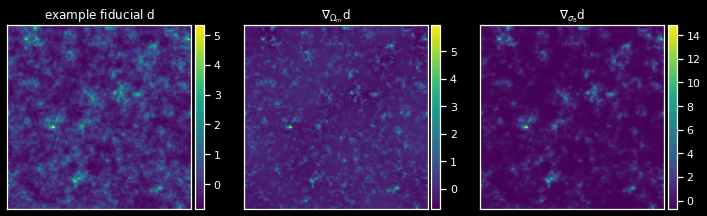

In [19]:
#@title visualize a fiducial universe and gradients <font color='lightgreen'>[run me]</font>
from imnn.utils import value_and_jacrev, value_and_jacfwd

def simulator_gradient(rng, θ, simulator_args=simulator_args):
    return value_and_jacrev(simulator, argnums=1, allow_int=True, holomorphic=True)(rng, θ, simulator_args=simulator_args)

simulation, simulation_gradient = value_and_jacfwd(simulator, argnums=1)(rng, θ_fid, 
                                                        simulator_args=simulator_args)
cmap = 'viridis'
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(12,15))

im1 = ax[0].imshow(np.squeeze(simulation), 
                   extent=(0,1,0,1), cmap=cmap)
ax[0].title.set_text(r'example fiducial $\rm d$')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im1 = ax[1].imshow(np.squeeze(simulation_gradient).T[0].T, 
                   extent=(0,1,0,1), cmap=cmap)
ax[1].title.set_text(r'$\nabla_{\Omega_m} \rm d$')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im1 = ax[2].imshow(np.squeeze(simulation_gradient).T[1].T, 
                   extent=(0,1,0,1), cmap=cmap)
ax[2].title.set_text(r'$\nabla_{\sigma_8} \rm d$')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    
plt.show()

Nice ! Since we can differentiate our universe and power spectrum, we can also compute the theoretical Fisher information embedded in the$128\times128$ field at the fiducial model:

---
## Training an IMNN

![imnn-diagram](https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/imnn-scheme-white.png)
$\quad$



The details behind the IMNN algorithm [can be found here on arxiv](https://arxiv.org/abs/1802.03537), but we'll summarize the gist briefly:



1.   We want to maximise the Fisher information, $\textbf{F}$, of compressed summaries to satisfy the Cramer-Rao bound:
    $$ \langle (\vartheta_\alpha - \langle \vartheta_\alpha \rangle )      (\vartheta_\beta - \langle \vartheta_\beta
    \rangle) \rangle \geq \textbf{F}^{-1}_{\alpha \beta} $$  which means saturating the Fisher information minimizes the average variance of the parameter estimates.

2.   To do this, we compute a pseudolikelihood to compute our Fisher information:
$$     -2 \ln \mathcal{L}(\textbf{x} | \textbf{d}) = (\textbf{x} - \boldsymbol{\mu}_f(\vartheta))^T \textbf{C}_f^{-1}(\textbf{x} - \boldsymbol{\mu}_f(\vartheta)) $$ where $\boldsymbol{\mu}_f$ and $\textbf{C}$ are the mean and covariance of the network output (summaries). The Fisher is then $$ \textbf{F}_{\alpha \beta} =  {\rm tr} [\boldsymbol{\mu}_{f,\alpha}^T C^{-1}_f \boldsymbol{\mu}_{f, \beta}] $$


Since we can differentiate through our neural network *and* simulated universe, we have the exact derivatives with respect to the pipeline we need to compute the Fisher matrix of compressed summaries on-the-fly during compression training. 
___

### Q: wait -- what if my simulator isn't differentiable ?
We don't *need* to have the exact derivatives for IMNN training ! Having the gradients accessible just means that we don't have to optimize finite-differencing for estimating derivatives by hand, however (as is done in the original IMNN paper).



___


Let's train an IMNN on cosmological fields to see how much information we can extract an what sort of constraints we can get. We will use 2000 simulations to estimate the covariance and use all of their derivatives and we'll summarise the whole cosmological field using 2 summaries.

In [21]:
n_s = 200     # number of simulations used to estimate covariance of network outputs
n_d = n_s     # number of simulations used to estimate the numerical derivative of
              # the mean of the network outputs
n_summaries = 2

We're going to use a fully convolutional inception network built using stax with some custom designed blocks. The inception block itself is implemented in the following block:

In [22]:
#@title nn model stuff <font color='lightgreen'>[RUN ME]</font>
def InceptBlock(filters, strides, do_5x5=True, do_3x3=True):
    """InceptNet convolutional striding block.
    filters: tuple: (f1,f2,f3)
    filters1: for conv1x1
    filters2: for conv1x1,conv3x3
    filters3L for conv1x1,conv5x5"""
    
    filters1, filters2, filters3 = filters
    conv1x1 = stax.serial(stax.Conv(filters1, (1, 1), strides, padding="SAME"))
    
    filters4 = filters2
    conv3x3 = stax.serial(stax.Conv(filters2, (1, 1), strides=None, padding="SAME"),
                        stax.Conv(filters4, (3, 3), strides, padding="SAME"))
                        
    filters5 = filters3
    conv5x5 = stax.serial(stax.Conv(filters3, (1, 1), strides=None, padding="SAME"),
                         stax.Conv(filters5, (5, 5), strides, padding="SAME")) 
    
    maxpool = stax.serial(stax.MaxPool((3, 3), padding="SAME"),
                         stax.Conv(filters4, (1, 1), strides, padding="SAME"))
                            
    if do_3x3:
        if do_5x5:
            return stax.serial(
                  stax.FanOut(4),
                  stax.parallel(conv1x1, conv3x3, conv5x5, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
        else:
            return stax.serial(
                  stax.FanOut(3),
                  stax.parallel(conv1x1, conv3x3, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
    else:
        return stax.serial(
              stax.FanOut(2),
              stax.parallel(conv1x1, maxpool),
              stax.FanInConcat(), 
              stax.LeakyRelu)

We'll also want to make sure that the output of the network is the correct shape, for which we'll introduce a Reshaping layer

In [23]:
def Reshape(shape):
    """Layer function for a reshape layer."""
    init_fun = lambda rng, input_shape: (shape,())
    apply_fun = lambda params, inputs, **kwargs: np.reshape(inputs, shape)
    return init_fun, apply_fun

Now we can build the network, with 64 filters and strides of 4 in each direction in each layer

In [24]:
fs = 55
layers = [
        InceptBlock((fs, fs, fs), strides=(4, 4)),
        InceptBlock((fs, fs, fs), strides=(4, 4)),
        InceptBlock((fs, fs, fs), strides=(4, 4)),
        InceptBlock((fs, fs, fs), strides=(2, 2), do_5x5=False, do_3x3=False),
        stax.Conv(n_summaries, (1, 1), strides=(1, 1), padding="SAME"),
        stax.Flatten,
        Reshape((n_summaries,))    
]
model = stax.serial(*layers)

We'll also introduce a function to check our model output:

In [25]:
def print_model(layers, input_shape, rng):
    print('input_shape: ', input_shape)
    for l in range(len(layers)):
        _m = stax.serial(*layers[:l+1])
        print('layer %d shape: '%(l+1), _m[0](rng, input_shape)[0])

# print model specs
key,rng = jax.random.split(rng)
input_shape = (1,) + shape + (1,)

print_model(layers, input_shape, rng)

input_shape:  (1, 128, 128, 1)
layer 1 shape:  (1, 32, 32, 220)
layer 2 shape:  (1, 8, 8, 220)
layer 3 shape:  (1, 2, 2, 220)
layer 4 shape:  (1, 1, 1, 110)
layer 5 shape:  (1, 1, 1, 2)
layer 6 shape:  (1, 2)
layer 7 shape:  (2,)


We'll also grab an adam optimiser from jax.experimental.optimizers

In [26]:
optimiser = optimizers.adam(step_size=1e-3)

Note that due to the form of the network we'll want to have simulations that have a "channel" dimension, which we can set up by not allowing for squeezing in the simulator.

### Train an IMNN

Finally we can train an IMNN to maxmise the Fisher information of its summaries and compare its compression efficiency to the theoretical Fisher.

We've used a SimulatorIMNN trained on new simulations on-the-fly.


In [27]:
# initialize IMNN with pre-trained state
rng, key = jax.random.split(rng)
IMNN = imnn.IMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=(1,) + shape + (1,),
        θ_fid=θ_fid,
        model=model,
        optimiser=optimiser,
        key_or_state=key,  # <---- initialize with state
        simulator=lambda rng, θ: simulator(
            rng, θ, simulator_args={
                **simulator_args, 
                **{"squeeze": False}}))

`simulator` provided, using SimulatorIMNN


In [34]:
%%time
rng, key = jax.random.split(rng)
IMNN.fit(λ=10., ϵ=0.1, rng=key, print_rate=None, min_iterations=500, best=True, patience=500)

CPU times: user 41min 24s, sys: 1min 53s, total: 43min 17s
Wall time: 42min 49s


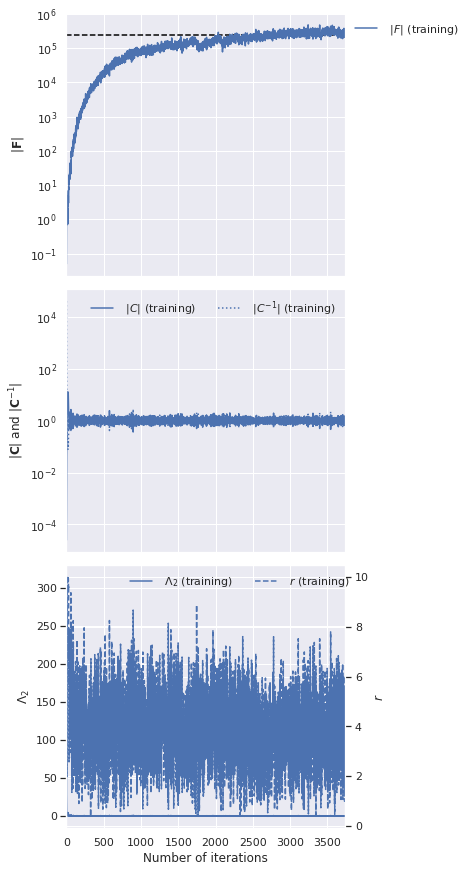

In [35]:
sns.set()
ax = IMNN.plot(expected_detF=np.linalg.det(F));
ax[0].set_yscale('log')

In [36]:
print('det F from IMNN:', np.linalg.det(IMNN.F))

det F from IMNN: 333175.6


In [37]:
print('% Fisher information captured by IMNN: ', np.linalg.det(IMNN.F) / np.linalg.det(F))

% Fisher information captured by IMNN:  1.3569961901448244


In [38]:
print('difference in Shannon information captured by IMNN: ', 0.5*(np.log(np.linalg.det(IMNN.F)) - np.log(np.linalg.det(F))))

difference in Shannon information captured by IMNN:  0.15263678838265804


In [48]:
np.save('cosmo-IMNN-history', IMNN.history['detF'])
np.save('cosmo-IMNN-F', IMNN.F)
np.save('cosmo-IMNN-fid', IMNN.θ_fid)
np.save('cosmo-IMNN-theory-F', F)
np.save('cosmo-IMNN-theory-detF', np.linalg.det(F))